# Problem 1, Implementing a Neural Net from Scratch

In [26]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Adding dataset

In [27]:
training_data = datasets.FashionMNIST(root="data", 
                                      train=True, 
                                      download=True, 
                                      transform=ToTensor())
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor())
labels_dict = {0:"T-shirt",
               1:"Trouser",
               2:"Pullover",
               3:"Dress",
               4:"Coat",
               5:"Sandal",
               6:"Shirt",
               7:"Sneaker",
               8:"Bag",
               9:"Ankle boot"}

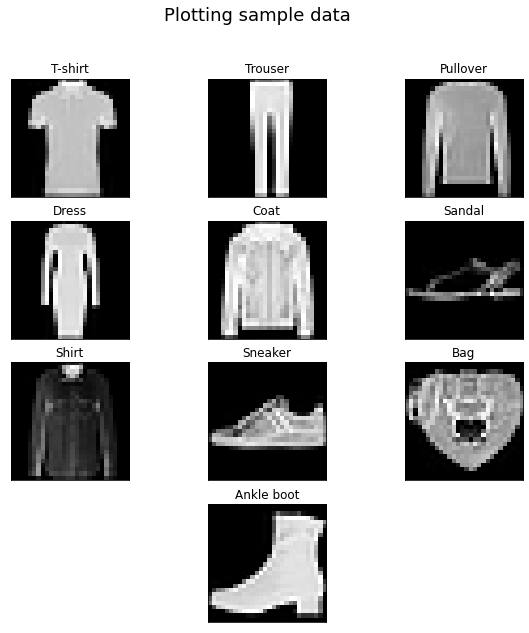

In [28]:
# get data sample
selected_imgs = torch.zeros((10, 1, 28, 28))
dl = DataLoader(training_data, batch_size=1000, shuffle=True)
data_subset = next(iter(dl))
for i in range(10):
    while(1):
        imgs_labels = data_subset[1]
        all_label_i = np.where(imgs_labels == i)[0]
        if len(all_label_i): 
            idx = np.random.choice(all_label_i, 1)
            selected_imgs[i, ...] = data_subset[0][idx].clone()
            break
        else:
            data_subset = next(iter(dl))

# plot sample data
fig, ax = plt.subplots(4, 3, figsize=(10,10))
fig.suptitle("Plotting sample data", fontsize=18)
fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 2])
for i in range(10):
    ax[i//3,i%3].set_xticks([])
    ax[i//3,i%3].set_yticks([])
    ax[i//3,i%3].imshow(selected_imgs[i, 0], cmap='gray')
    ax[i//3,i%3].set_title(labels_dict[i])
ax[3,1].set_xticks([])
ax[3,1].set_yticks([])
ax[3,1].imshow(selected_imgs[9, 0], cmap='gray')
ax[3,1].set_title(labels_dict[i])
plt.show()

## Implementing network